# **Assignment I -  Image Classification with Convolutional Neural Network**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  **PartA: Implementing Convolutional Neural Network from scratch**

## **Data Understanding, Analysis, Visualization and Cleaning**


**Q1:** What does the dataset represent?

**Ans:** A image classification dataset of four classes of traffic sign: No Passing, OverSpeed, Instructions, Cautions. Each class contains trafficsigns  intended to train a CNN to recognize traffic sign symbols from images.

**Q2:** *How many total images are in the dataset?*

**Ans:** The dataset contains a total of:

*   **Per class:** 5500 images

###    **Total:** 4 classes × 5500 = 22,000 images

**Q3:** *What is the distribution of images across different classes?*

> **Ans:** Uniform distribution: Each class has exactly 5500 samples, ensuring no class imbalance.

| Character   |   Images |
| ----------- | -------: |
| NoPassing   |     5500 |
| OverSpeed   |     5500 |
| Instructions|     5500 |
| Cautions    |     5500 |
| **Total**   |**22,000**|




**Q4:** *How is the dataset split into training and validation sets?*

> **Ans:** In our approach, the dataset is initially divided into 80% training and 20% testing by organizing images into separate folders (/train/ and /test/). To create a validation set, we further split the training data using a 20% validation split. This means:

*   From original full dataset:
  *   **80% → used for training/validation**
        * From then 80%, 64% is used for training
        * 16% is used for validation
  *   **20% → used as a separate test set** (completely held out during training)










**Q5:** *What preprocessing techniques (e.g., resizing, normalization) were applied?*


* Resizing: All images rescaled to 224 × 224 pixels using bicubic interpolation.

* Colour conversion: Converted all images to RGB channels (discarding any alpha/transparency).

* Format standardization: Saved as high-quality JPG.

* Corruption check: Discarded unreadable files via PIL’s `.verify()`.

**Q6:** *What data generators, if any, were used for preprocessing and augmentation?*

> **Ans:** Data augmentation is applied using TensorFlow's `Sequential` data pipeline with `layers. RandomFlip`, `layers.RandomRotation`, etc. No traditional `ImageDataGenerator` was used as `tf.data` pipeline is more efficient for modern usage.

**Installing and Importing Necessary Libraries**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools, datetime, time, json, pathlib
import shutil
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model


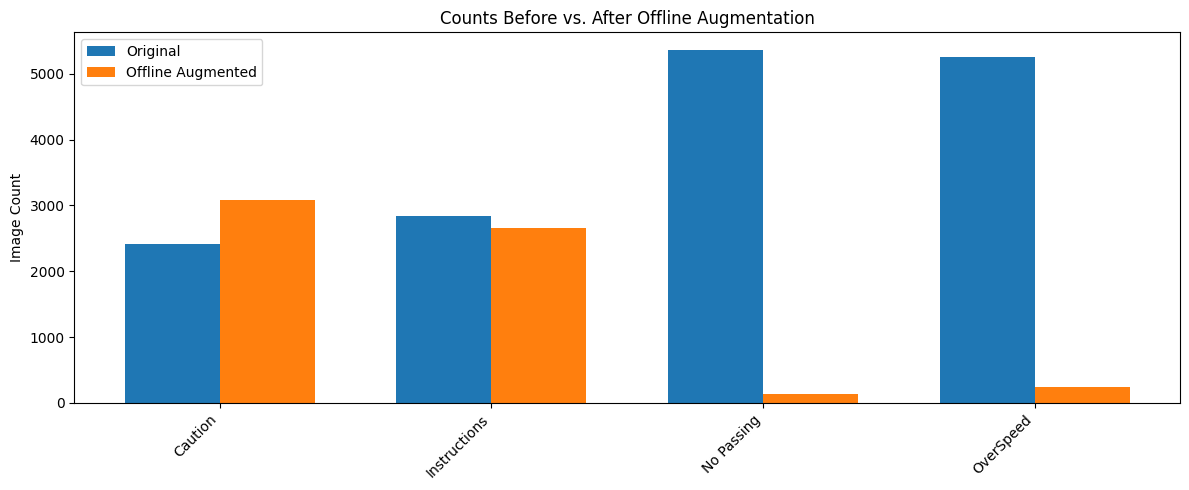

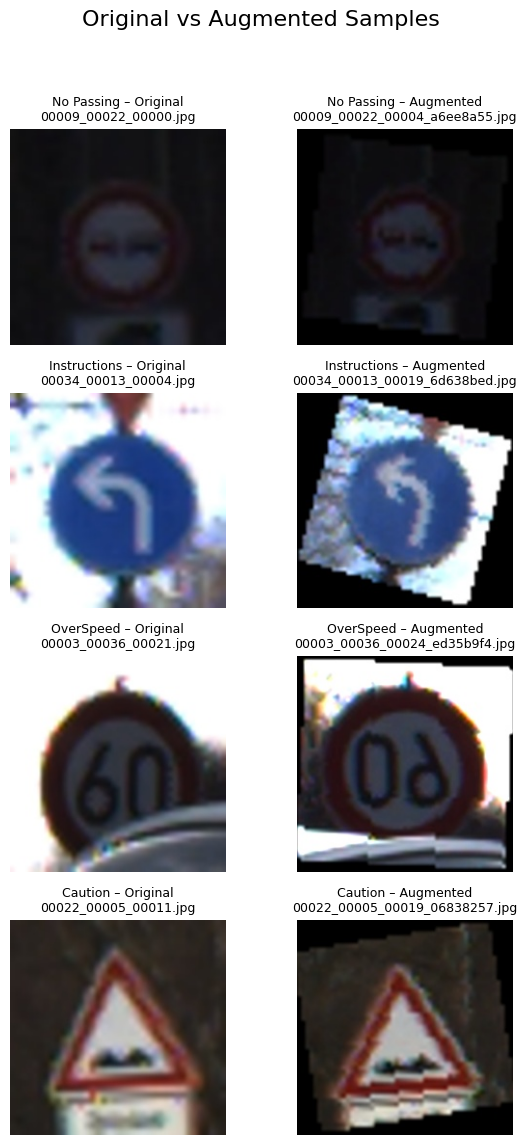

In [ ]:
CLEAN_DIR = Path("/content/drive/Shareddrives/neha/New_dataset")

if not CLEAN_DIR.exists():
    raise FileNotFoundError(f"{CLEAN_DIR} not found – update the path above.")

orig_counts, aug_counts = {}, {}

# Returns stem before the 2nd underscore (or whole stem if only one underscore)
def base_key(path):
    parts = path.stem.split("_")
    return "_".join(parts[:2])

paired_samples = []  # will hold (class, original_path, augmented_path)

for cls_dir in sorted(p for p in CLEAN_DIR.iterdir() if p.is_dir()):
    originals   = {p.stem: p for p in cls_dir.glob("*.jpg") if p.stem.count("_") == 2}
    augmenteds  = [p for p in cls_dir.glob("*.jpg") if p.stem.count("_") >= 3]

    # count stats
    orig_counts[cls_dir.name] = len(originals)
    aug_counts[cls_dir.name]  = len(augmenteds)

    # build prefix-map from originals
    orig_prefix_map = {base_key(p): p for p in originals.values()}

    # find augmented that share prefix with an original
    matches = [(orig_prefix_map[base_key(aug)], aug)
               for aug in augmenteds if base_key(aug) in orig_prefix_map]

    # add a random match (if any) for demo grid
    if matches:
        paired_samples.append( (cls_dir.name, *random.choice(matches)) )

# Bar chart
labels = list(orig_counts.keys())
x, w   = range(len(labels)), 0.35
plt.figure(figsize=(12,5))
plt.bar([i-w/2 for i in x], [orig_counts[c] for c in labels], w, label="Original")
plt.bar([i+w/2 for i in x], [aug_counts[c]  for c in labels], w, label="Offline Augmented")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Image Count")
plt.title("Counts Before vs. After Offline Augmentation")
plt.legend(); plt.tight_layout(); plt.show()

# Show original-vs-its-augmented pairs
# Check if paired_samples is empty and handle it
if paired_samples:
    pairs_to_show = random.sample(paired_samples, min(4, len(paired_samples)))

    fig, axes = plt.subplots(len(pairs_to_show), 2, figsize=(6, 3*len(pairs_to_show)))
    fig.suptitle("Original vs Augmented Samples", fontsize=16)

    for i, (cls, orig_path, aug_path) in enumerate(pairs_to_show):
        orig_img = Image.open(orig_path).convert("RGB").resize((224,224))
        aug_img  = Image.open(aug_path ).convert("RGB").resize((224,224))

        axes[i,0].imshow(orig_img); axes[i,0].axis("off")
        axes[i,0].set_title(f"{cls} – Original\n{orig_path.name}", fontsize=9)

        axes[i,1].imshow(aug_img);  axes[i,1].axis("off")
        axes[i,1].set_title(f"{cls} – Augmented\n{aug_path.name}", fontsize=9)

    plt.tight_layout(rect=[0,0.03,1,0.95]); plt.show()
else:
    print("No matching original and augmented image pairs found.")

**Initial Setup and Configuration for Image Classification using TensorFlow**

In [ ]:
print("TensorFlow", tf.__version__)
IMG_SIZE   = (64, 64)
BATCH      = 64
CLASSES    = 4
train_dir = '/content/drive/Shareddrives/neha/clean_dataset/train'
test_dir = '/content/drive/Shareddrives/neha/clean_dataset/test'
SEED       = 42

TensorFlow 2.18.0


In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH
)
val_ds   = keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH
)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 17600 files belonging to 4 classes.
Using 14080 files for training.
Found 17600 files belonging to 4 classes.
Using 3520 files for validation.
Found 4400 files belonging to 4 classes.
Classes: ['Caution', 'Instructions', 'No Passing', 'OverSpeed']


**Visualize Agumentation**

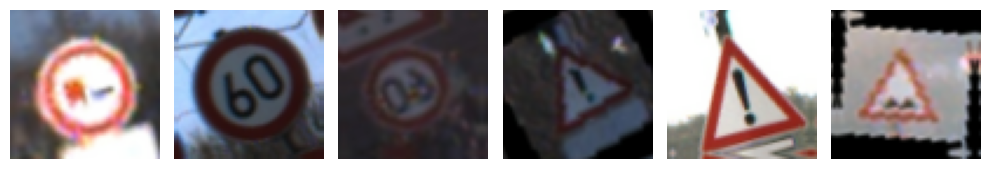

In [ ]:
# simple augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
# visualise
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,3))
    for i in range(6):
        ax = plt.subplot(1,6,i+1); plt.axis("off")
        aug = data_augmentation(images)[i] / 255.0
        plt.imshow(aug)
    break
plt.tight_layout()


**Visualize Images**

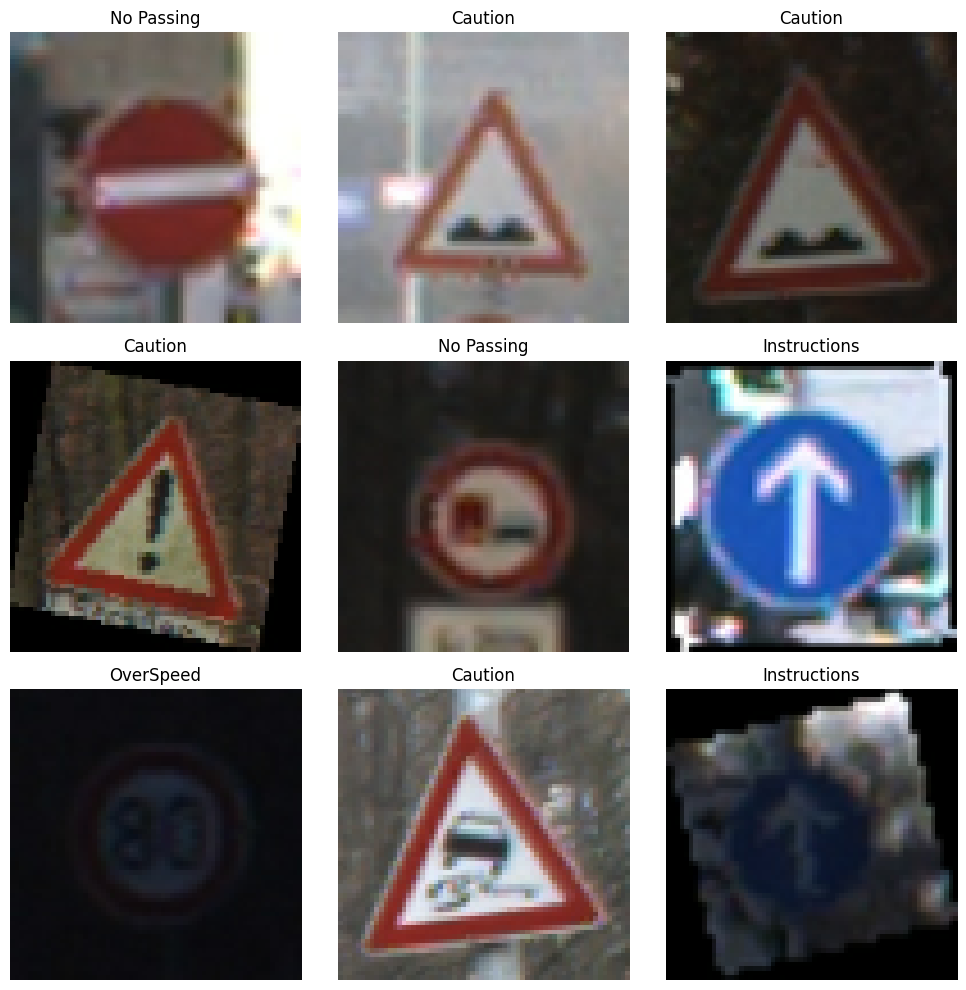

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    images = images / 255.0
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

### **Building BaseLine CNN Model**

In [ ]:
def build_baseline():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64 , activation='relu'),
        layers.Dense(CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

base_model = build_baseline()
base_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,564 (5.01 MB)

 Trainable params: 1,314,564 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [ ]:
EPOCHS = 20
hist_base = base_model.fit(
    train_ds.map(lambda x,y: (data_augmentation(x), y)),
    validation_data=val_ds, epochs=EPOCHS
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.6626 - loss: 0.7787 - val_accuracy: 0.9690 - val_loss: 0.0985
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 50s 226ms/step - accuracy: 0.9700 - loss: 0.0961 - val_accuracy: 0.9884 - val_loss: 0.0405
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 84s 234ms/step - accuracy: 0.9867 - loss: 0.0432 - val_accuracy: 0.9886 - val_loss: 0.0337
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - accuracy: 0.9934 - loss: 0.0215 - val_accuracy: 0.9923 - val_loss: 0.0239
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 81s 222ms/step - accuracy: 0.9932 - loss: 0.0204 - val_accuracy: 0.9943 - val_loss: 0.0217
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 222ms/step - accuracy: 0.9939 - loss: 0.0197 - val_accuracy: 0.9918 - val_loss: 0.0234
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 227ms/step - accuracy: 0.9927 - loss: 0.0210 - val_accuracy: 0.9952 - val_loss: 0.0183
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.9963 - loss: 0

In [ ]:
base_model.save("/content/drive/Shareddrives/neha/baseline.keras")

In [ ]:
import json

# Save
with open('/content/drive/Shareddrives/neha/hist_base.json', 'w') as f:
    json.dump(hist_base.history, f)

**Model Evaluation**

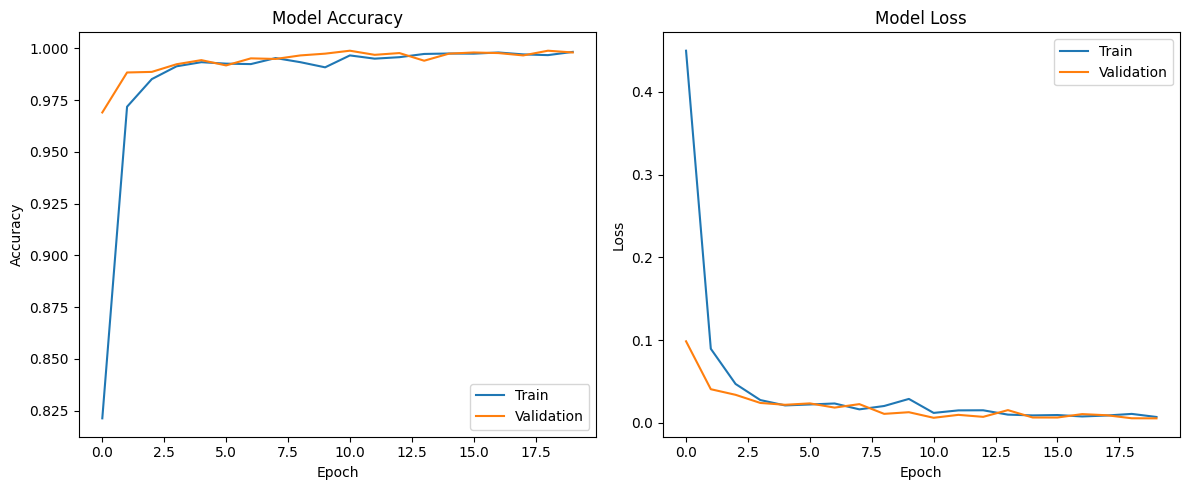

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_base.history['accuracy'])
plt.plot(hist_base.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(hist_base.history['loss'])
plt.plot(hist_base.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
base_model = keras.models.load_model("/content/drive/Shareddrives/neha/baseline.keras")

**Test Set Evaluation Results**

In [ ]:
# Evaluate the model on the test dataset
print("Evaluating model on test dataset...")
test_loss, test_acc = base_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Evaluating model on test dataset...
69/69 ━━━━━━━━━━━━━━━━━━━━ 774s 11s/step - accuracy: 0.9983 - loss: 0.0054
Test accuracy: 0.9977
Test loss: 0.0061


In [ ]:
# Classification report on unseen data
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = tf.argmax(base_model.predict(images, verbose=0), axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
class_names = ['Cautions', 'No Passing', 'Instructions', 'OverSpeed']

print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4))

              precision    recall  f1-score   support

    Cautions     0.9973    0.9991    0.9982      1100
  No Passing     1.0000    0.9964    0.9982      1100
Instructions     0.9991    0.9964    0.9977      1100
   OverSpeed     0.9946    0.9991    0.9968      1100

    accuracy                         0.9977      4400
   macro avg     0.9977    0.9977    0.9977      4400
weighted avg     0.9977    0.9977    0.9977      4400



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


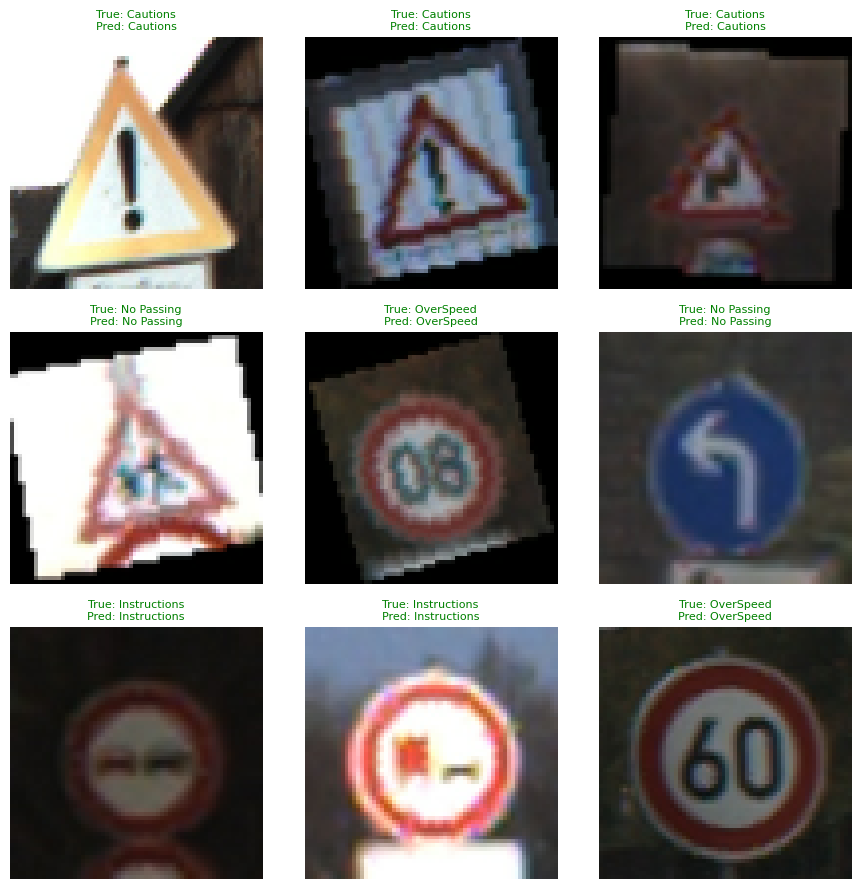

In [ ]:
# Visualise predictions on unseen data
import matplotlib.pyplot as plt
import numpy as np

vis_model = base_model

# pick one batch from the validation pipeline
for images, labels in test_ds.take(1):
    preds = np.argmax(vis_model.predict(images), axis=1)
    plt.figure(figsize=(9, 9))
    for i in range(9):                         # show first 9 samples
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        correct = preds[i] == labels[i]
        title_color = "green" if correct else "red"
        plt.title(
            f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}",
            color=title_color, fontsize=8
        )
        plt.axis("off")
    plt.tight_layout()
    break


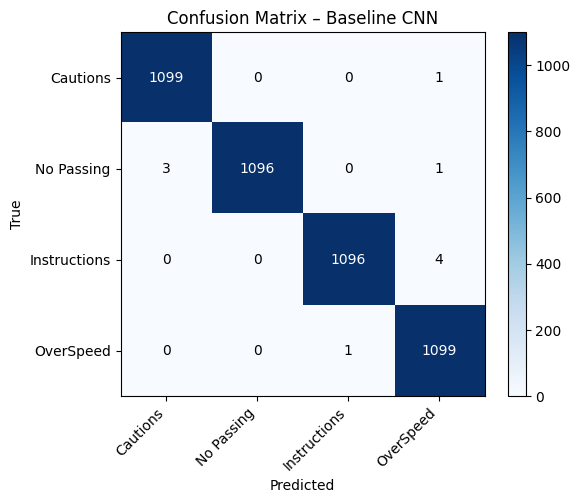

In [ ]:
# Confusion matrix on test dataset
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Baseline CNN")
plt.colorbar()

ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
th = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             ha="center", va="center",
             color="white" if cm[i, j] > th else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## **Deeper + Regularised CNN**

In [ ]:
# Build model
def build_deeper_model():
    l2_reg = 1e-4

    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
        data_augmentation,

        layers.Conv2D(32, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
deep_model = build_deeper_model()
deep_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,308 (1.86 MB)

 Trainable params: 485,860 (1.85 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Callbacks
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = f"./checkpoints/{timestamp}"
log_dir = f"./logs/{timestamp}"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.h5'),
        monitor='val_accuracy', save_best_only=True, verbose=1
    ),
    EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
    ),
    TensorBoard(log_dir=log_dir)
]


**Model Training**

In [ ]:
# Train
EPOCHS = 50
print("Training started...")
start_time = time.time()
history = deep_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)
end_time = time.time()
print(f"Model training completed in {(end_time - start_time)/60:.2f} minutes")

Training started...
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6757 - loss: 0.8141 
Epoch 1: val_accuracy improved from -inf to 0.26193, saving model to ./checkpoints/20250512-172201/best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 3378s 15s/step - accuracy: 0.6763 - loss: 0.8128 - val_accuracy: 0.2619 - val_loss: 2.7770 - learning_rate: 0.0010
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9461 - loss: 0.1780
Epoch 2: val_accuracy improved from 0.26193 to 0.87955, saving model to ./checkpoints/20250512-172201/best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9461 - loss: 0.1778 - val_accuracy: 0.8795 - val_loss: 0.3294 - learning_rate: 0.0010
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9783 - loss: 0.0974
Epoch 3: val_accuracy improved from 0.87955 to 0.98807, saving model to ./checkpoints/20250512-172201/best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9783 - loss: 0.0974 - val_accuracy: 0.9881 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9833 - loss: 0.0868
Epoch 4: val_accuracy improved from 0.98807 to 0.99347, saving model to ./checkpoints/20250512-172201/best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9834 - loss: 0.0868 - val_accuracy: 0.9935 - val_loss: 0.0587 - learning_rate: 0.0010
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9900 - loss: 0.0681
Epoch 5: val_accuracy did not improve from 0.99347
220/220 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9900 - loss: 0.0682 - val_accuracy: 0.9906 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9906 - loss: 0.0675
Epoch 6: val_accuracy improved from 0.99347 to 0.99403, saving model to ./checkpoints/20250512-172201/best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9906 - loss: 0.0675 - val_accuracy: 0.9940 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9908 - loss: 0.0649
Epoch 7: val_accuracy improved from 0.99403 to 0.99687, saving model to ./checkpoints/20250512-172201/best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.9908 - loss: 0.0649 - val_accuracy: 0.9969 - val_loss: 0.0461 - learning_rate: 0.0010
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.0625
Epoch 8: val_accuracy improved from 0.99687 to 0.99886, saving model to ./checkpoints/20250512-172201/best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.9914 - loss: 0.0625 - val_accuracy: 0.9989 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9933 - loss: 0.0562
Epoch 9: val_accuracy did not improve from 0.99886
220/220 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9933 - loss: 0.0562 - val_accuracy: 0.9929 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9948 - loss: 0.0536
Epoch 10: val_accuracy did not improve from 0.99886
220/220 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9948 - loss: 0.0535 - val_accuracy: 0.9787 - val_loss: 0.0945 - learning_rate: 0.0010
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9942 - loss: 0.0540
Epoch 11: val_accuracy did not improve from 0.99886
220/220 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9942 - loss: 0.0540 - val_accuracy: 0.9989 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 12/50
220/220 

220/220 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.9953 - loss: 0.0534 - val_accuracy: 0.9994 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 14/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9939 - loss: 0.0575
Epoch 14: val_accuracy did not improve from 0.99943
220/220 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.9939 - loss: 0.0575 - val_accuracy: 0.9980 - val_loss: 0.0464 - learning_rate: 0.0010
Epoch 15/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - loss: 0.0485
Epoch 15: val_accuracy did not improve from 0.99943
220/220 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9969 - loss: 0.0486 - val_accuracy: 0.9901 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 16/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9955 - loss: 0.0529
Epoch 16: val_accuracy did not improve from 0.99943
220/220 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.9955 - loss: 0.0530 - val_accuracy: 0.9969 - val_loss: 0.0457 - learning_rate: 0.0010
Epoch 17/50
220/22

**Model Evaluation**

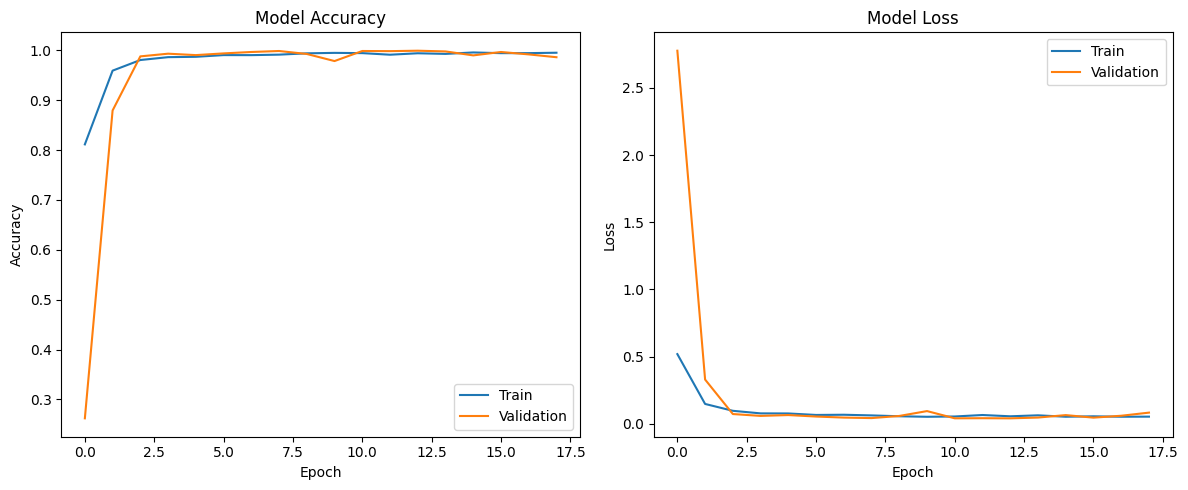

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
deep_model.save("/content/drive/Shareddrives/neha/deepmodel.keras")

In [ ]:
import json

# Save
with open('/content/drive/Shareddrives/neha/deep_history1.json', 'w') as f:
    json.dump(history.history, f)

**Test Set Evaluation Results**

In [ ]:
# Evaluation
test_loss, test_acc = deep_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 774s 11s/step - accuracy: 0.9996 - loss: 0.0402
Test Accuracy: 0.9991
Test Loss: 0.0415


In [ ]:
# Deep model classification report on unseen data
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = tf.argmax(deep_model.predict(images, verbose=0), axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
class_names = ['Cautions', 'No Passing', 'Instructions', 'OverSpeed']

print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4))

              precision    recall  f1-score   support

    Cautions     0.9964    1.0000    0.9982      1100
  No Passing     1.0000    1.0000    1.0000      1100
Instructions     1.0000    0.9973    0.9986      1100
   OverSpeed     1.0000    0.9991    0.9995      1100

    accuracy                         0.9991      4400
   macro avg     0.9991    0.9991    0.9991      4400
weighted avg     0.9991    0.9991    0.9991      4400



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


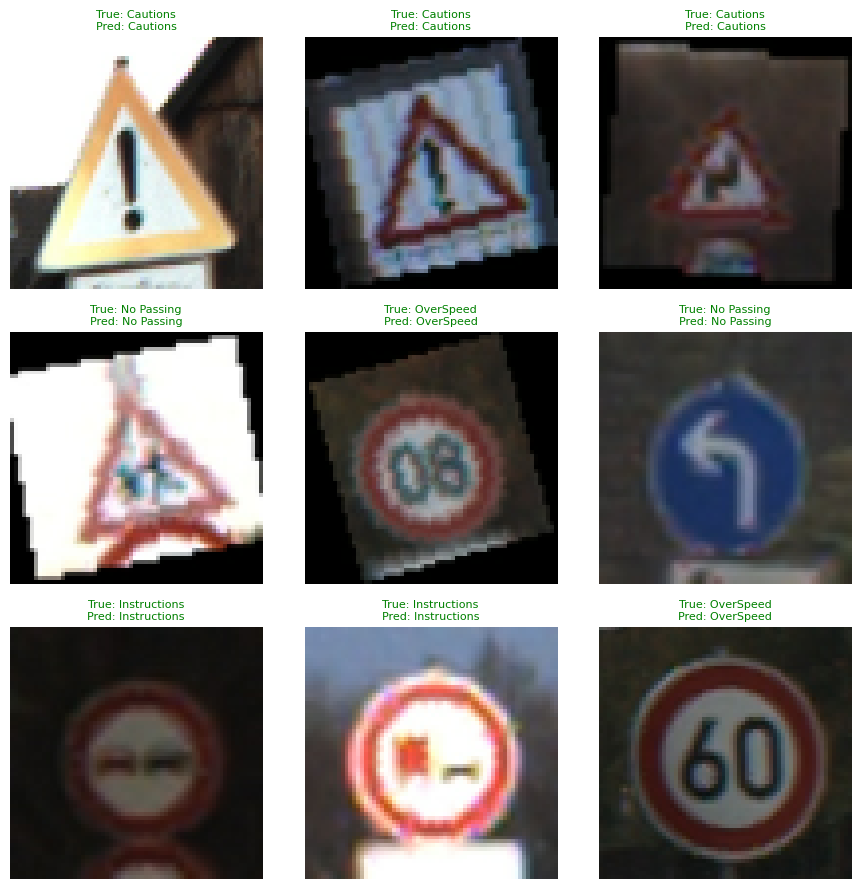

In [ ]:
# Deeper model: Visualise predictions on unseen data
import matplotlib.pyplot as plt
import numpy as np

vis_model = deep_model

# pick one batch from the validation pipeline
for images, labels in test_ds.take(1):
    preds = np.argmax(vis_model.predict(images), axis=1)
    plt.figure(figsize=(9, 9))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        correct = preds[i] == labels[i]
        title_color = "green" if correct else "red"
        plt.title(
            f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}",
            color=title_color, fontsize=8
        )
        plt.axis("off")
    plt.tight_layout()
    break


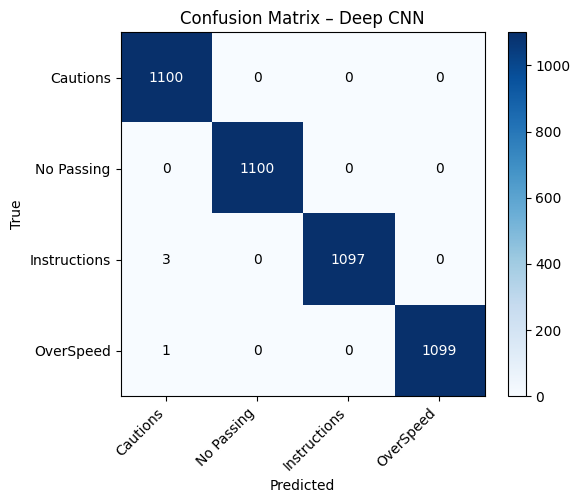

In [ ]:
# Confusion matrix on test dataset
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Deep CNN")
plt.colorbar()

ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
th = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             ha="center", va="center",
             color="white" if cm[i, j] > th else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**Using SGD Optimizer**

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model_sgd.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)
callbacks = [checkpoint_cb, earlystop_cb]  # New callbacks for SGD


In [ ]:
# Recompile with sgd to comapre
sgd_deep_model = build_deeper_model()
sgd_deep_model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Model Training**

In [ ]:
hist_sgd = sgd_deep_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4832 - loss: 1.1464
Epoch 1: val_accuracy improved from -inf to 0.25852, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.4836 - loss: 1.1457 - val_accuracy: 0.2585 - val_loss: 1.5127
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6901 - loss: 0.7925
Epoch 2: val_accuracy improved from 0.25852 to 0.54091, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.6902 - loss: 0.7923 - val_accuracy: 0.5409 - val_loss: 1.1592
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7857 - loss: 0.5975
Epoch 3: val_accuracy improved from 0.54091 to 0.83182, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.7858 - loss: 0.5973 - val_accuracy: 0.8318 - val_loss: 0.5064
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8591 - loss: 0.4197
Epoch 4: val_accuracy improved from 0.83182 to 0.83466, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8591 - loss: 0.4197 - val_accuracy: 0.8347 - val_loss: 0.4787
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8892 - loss: 0.3365
Epoch 5: val_accuracy improved from 0.83466 to 0.88523, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.8892 - loss: 0.3365 - val_accuracy: 0.8852 - val_loss: 0.3578
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9054 - loss: 0.2872
Epoch 6: val_accuracy improved from 0.88523 to 0.90710, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9055 - loss: 0.2872 - val_accuracy: 0.9071 - val_loss: 0.2769
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9293 - loss: 0.2269
Epoch 7: val_accuracy improved from 0.90710 to 0.94687, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9294 - loss: 0.2268 - val_accuracy: 0.9469 - val_loss: 0.1636
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9388 - loss: 0.1904
Epoch 8: val_accuracy improved from 0.94687 to 0.96136, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.9388 - loss: 0.1904 - val_accuracy: 0.9614 - val_loss: 0.1573
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9537 - loss: 0.1620
Epoch 9: val_accuracy did not improve from 0.96136
220/220 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9537 - loss: 0.1620 - val_accuracy: 0.9565 - val_loss: 0.1578
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9614 - loss: 0.1391
Epoch 10: val_accuracy improved from 0.96136 to 0.98153, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.9614 - loss: 0.1391 - val_accuracy: 0.9815 - val_loss: 0.0944
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9646 - loss: 0.1335
Epoch 11: val_accuracy did not improve from 0.98153
220/220 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.9646 - loss: 0.1335 - val_accuracy: 0.9716 - val_loss: 0.1263
Epoch 12/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9693 - loss: 0.1208
Epoch 12: val_accuracy improved from 0.98153 to 0.98665, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9693 - loss: 0.1208 - val_accuracy: 0.9866 - val_loss: 0.0767
Epoch 13/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9779 - loss: 0.1000
Epoch 13: val_accuracy did not improve from 0.98665
220/220 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9779 - loss: 0.1001 - val_accuracy: 0.8980 - val_loss: 0.3314
Epoch 14/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9779 - loss: 0.0992
Epoch 14: val_accuracy did not improve from 0.98665
220/220 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9778 - loss: 0.0992 - val_accuracy: 0.9838 - val_loss: 0.0821
Epoch 15/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9800 - loss: 0.0896
Epoch 15: val_accuracy improved from 0.98665 to 0.98807, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.9800 - loss: 0.0897 - val_accuracy: 0.9881 - val_loss: 0.0710
Epoch 16/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9836 - loss: 0.0813
Epoch 16: val_accuracy improved from 0.98807 to 0.99375, saving model to best_model_sgd.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9836 - loss: 0.0813 - val_accuracy: 0.9937 - val_loss: 0.0564
Epoch 17/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9826 - loss: 0.0847
Epoch 17: val_accuracy did not improve from 0.99375
220/220 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9826 - loss: 0.0847 - val_accuracy: 0.9923 - val_loss: 0.0581
Epoch 18/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9820 - loss: 0.0854
Epoch 18: val_accuracy did not improve from 0.99375
220/220 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9820 - loss: 0.0853 - val_accuracy: 0.9929 - val_loss: 0.0568
Epoch 19/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9847 - loss: 0.0763
Epoch 19: val_accuracy did not improve from 0.99375
220/220 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.9847 - loss: 0.0763 - val_accuracy: 0.9935 - val_loss: 0.0500
Epoch 20/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9857 - loss: 0.0730
Epoch 20: val_accuracy did n

In [ ]:
sgd_deep_model.save("/content/drive/Shareddrives/neha/sgd_model1.keras")

In [ ]:
import json

# Save
with open('/content/drive/Shareddrives/neha/sgd_history1.json', 'w') as f:
    json.dump(hist_sgd.history, f)

**Test Set Evaluation Results**

69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 429ms/step - accuracy: 0.9961 - loss: 0.0517
SGD Test Accuracy: 0.9955
SGD Test Loss: 0.0537


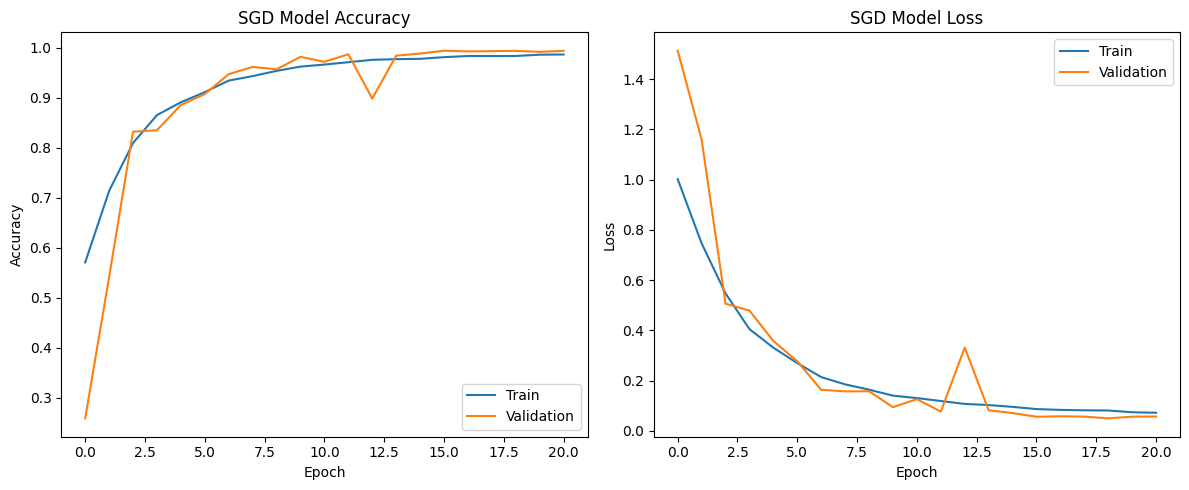

In [ ]:
# Evaluate the SGD model
test_loss_sgd, test_acc_sgd = sgd_deep_model.evaluate(test_ds)
print(f"SGD Test Accuracy: {test_acc_sgd:.4f}")
print(f"SGD Test Loss: {test_loss_sgd:.4f}")

# Plot training & validation accuracy and loss for SGD
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_sgd.history['accuracy'])
plt.plot(hist_sgd.history['val_accuracy'])
plt.title('SGD Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(hist_sgd.history['loss'])
plt.plot(hist_sgd.history['val_loss'])
plt.title('SGD Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


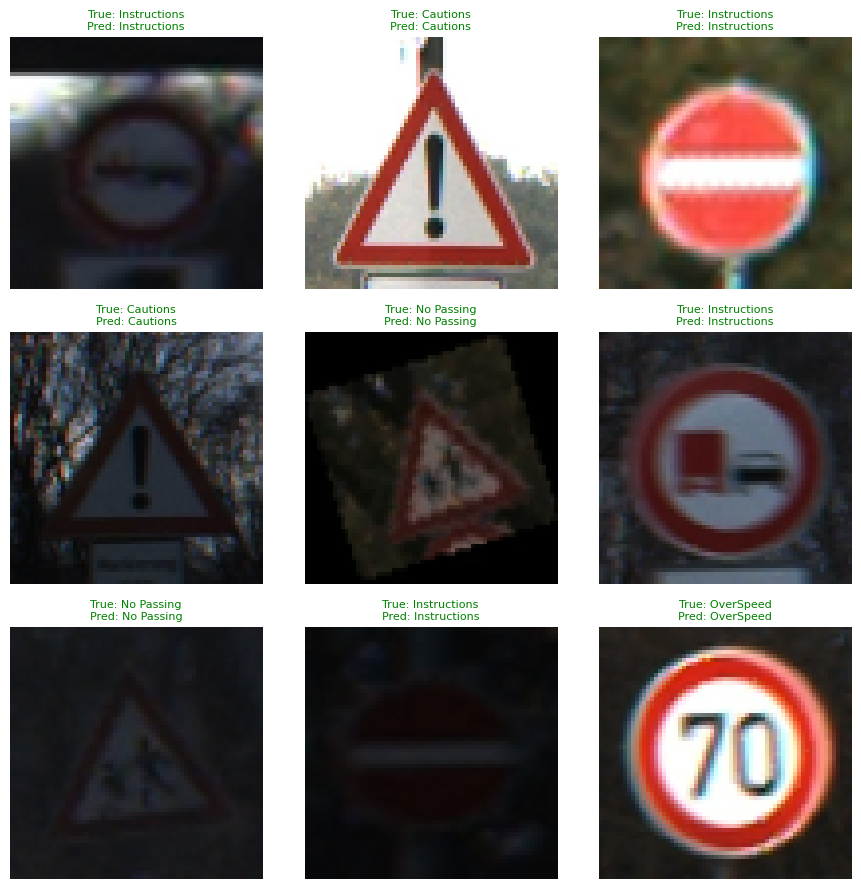

In [ ]:
# Visualise sgd model predictions on unseen data
vis_model = sgd_deep_model

# pick one batch from the validation pipeline
for images, labels in test_ds.take(1):
    preds = np.argmax(vis_model.predict(images), axis=1)
    plt.figure(figsize=(9, 9))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        correct = preds[i] == labels[i]
        title_color = "green" if correct else "red"
        plt.title(
            f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}",
            color=title_color, fontsize=8
        )
        plt.axis("off")
    plt.tight_layout()
    break


## **Part B: Fine- Tuning a Pre-Trained Model (Transfer Learning)**

In [ ]:
tl_data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
])

IMG_SIZE = (224, 224)
CLASSES = 4
INITIAL_EPOCHS = 10
FT_EPOCHS = 10
SEED = 42

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH
)


In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH
)


Found 17600 files belonging to 4 classes.
Using 14080 files for training.
Found 17600 files belonging to 4 classes.
Using 3520 files for validation.
Found 4400 files belonging to 4 classes.


In [ ]:
# Build the transfer-learning model

base = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
    pooling=None)               # we add pooling manually

base.trainable = False          # Feature-extraction first

inputs  = layers.Input(shape=IMG_SIZE + (3,))
x = tl_data_augmentation(inputs)
x = base(x, training=False)     # keep BN layers in inference mode
x = layers.GlobalAveragePooling2D()(x)#Converts the output feature map into a single vector
x = layers.Dropout(0.3)(x)#random units are set to zero
outputs = layers.Dense(CLASSES, activation='softmax')(x)

tl_model = models.Model(inputs, outputs)

In [ ]:
# Compile & Train
tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True)

hist_fe = tl_model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop])

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 763s 3s/step - accuracy: 0.6823 - loss: 0.8329 - val_accuracy: 0.9389 - val_loss: 0.1979
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 744s 3s/step - accuracy: 0.9264 - loss: 0.2264 - val_accuracy: 0.9543 - val_loss: 0.1380
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 711s 3s/step - accuracy: 0.9415 - loss: 0.1722 - val_accuracy: 0.9631 - val_loss: 0.1101
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 837s 4s/step - accuracy: 0.9459 - loss: 0.1554 - val_accuracy: 0.9668 - val_loss: 0.0957
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1086s 5s/step - accuracy: 0.9556 - loss: 0.1371 - val_accuracy: 0.9679 - val_loss: 0.0868
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1104s 5s/step - accuracy: 0.9543 - loss: 0.1244 - val_accuracy: 0.9699 - val_loss: 0.0811
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 969s 4s/step - accuracy: 0.9609 - loss: 0.1139 - val_accuracy: 0.9693 - val_loss: 0.0779
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 766s 3s/step - accuracy: 0.9610 - loss: 0.1131 - val_ac

In [ ]:
# Evaluate the TL model
test_loss_tl, test_acc_tl = tl_model.evaluate(test_ds)
print(f"TL Test Accuracy: {test_acc_tl:.4f}")
print(f"TL Test Loss: {test_loss_tl:.4f}")

# Plot training & validation accuracy and loss for TL
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_fe.history['accuracy'])
plt.plot(hist_fe.history['val_accuracy'])
plt.title('TL Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(hist_fe.history['loss'])
plt.plot(hist_fe.history['val_loss'])
plt.title('TL Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Fine-Tuning
# Unfreeze top N layers
unfreeze_at = len(base.layers) - 40
for layer in base.layers[unfreeze_at:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

hist_ft = tl_model.fit(
    train_ds,
    initial_epoch=hist_fe.epoch[-1] + 1,
    epochs=hist_fe.epoch[-1] + 1 + FT_EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop])

Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 854s 4s/step - accuracy: 0.9674 - loss: 0.0890 - val_accuracy: 0.9844 - val_loss: 0.0399
Epoch 12/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 859s 4s/step - accuracy: 0.9825 - loss: 0.0527 - val_accuracy: 0.9889 - val_loss: 0.0287
Epoch 13/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 882s 4s/step - accuracy: 0.9827 - loss: 0.0479 - val_accuracy: 0.9918 - val_loss: 0.0239
Epoch 14/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 815s 4s/step - accuracy: 0.9889 - loss: 0.0321 - val_accuracy: 0.9935 - val_loss: 0.0191
Epoch 15/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 890s 4s/step - accuracy: 0.9903 - loss: 0.0268 - val_accuracy: 0.9946 - val_loss: 0.0159
Epoch 16/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 877s 4s/step - accuracy: 0.9934 - loss: 0.0206 - val_accuracy: 0.9946 - val_loss: 0.0147
Epoch 17/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 819s 4s/step - accuracy: 0.9939 - loss: 0.0168 - val_accuracy: 0.9952 - val_loss: 0.0134
Epoch 18/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 806s 4s/step - accuracy: 0.9952 - loss: 0.0151 - 

In [ ]:
tl_model.save("/content/drive/Shareddrives/neha/tl_model.keras")

In [ ]:
import json

# Save
with open('/content/drive/Shareddrives/neha/tl_history.json', 'w') as f:
    json.dump(hist_ft.history, f)

In [ ]:
# TL classification report on unseen data
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = tf.argmax(tl_model.predict(images, verbose=0), axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
class_names = ['Cautions', 'No Passing', 'Instructions', 'OverSpeed']

print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4))

              precision    recall  f1-score   support

    Cautions     0.9955    0.9991    0.9973      1100
  No Passing     0.9991    0.9955    0.9973      1100
Instructions     0.9982    0.9991    0.9986      1100
   OverSpeed     1.0000    0.9991    0.9995      1100

    accuracy                         0.9982      4400
   macro avg     0.9982    0.9982    0.9982      4400
weighted avg     0.9982    0.9982    0.9982      4400



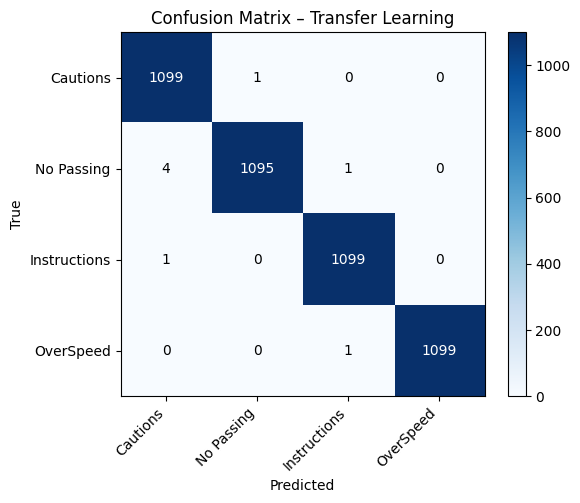

In [ ]:
# TL confusion matrix on test dataset
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Transfer Learning")
plt.colorbar()

ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
th = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             ha="center", va="center",
             color="white" if cm[i, j] > th else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 821ms/step


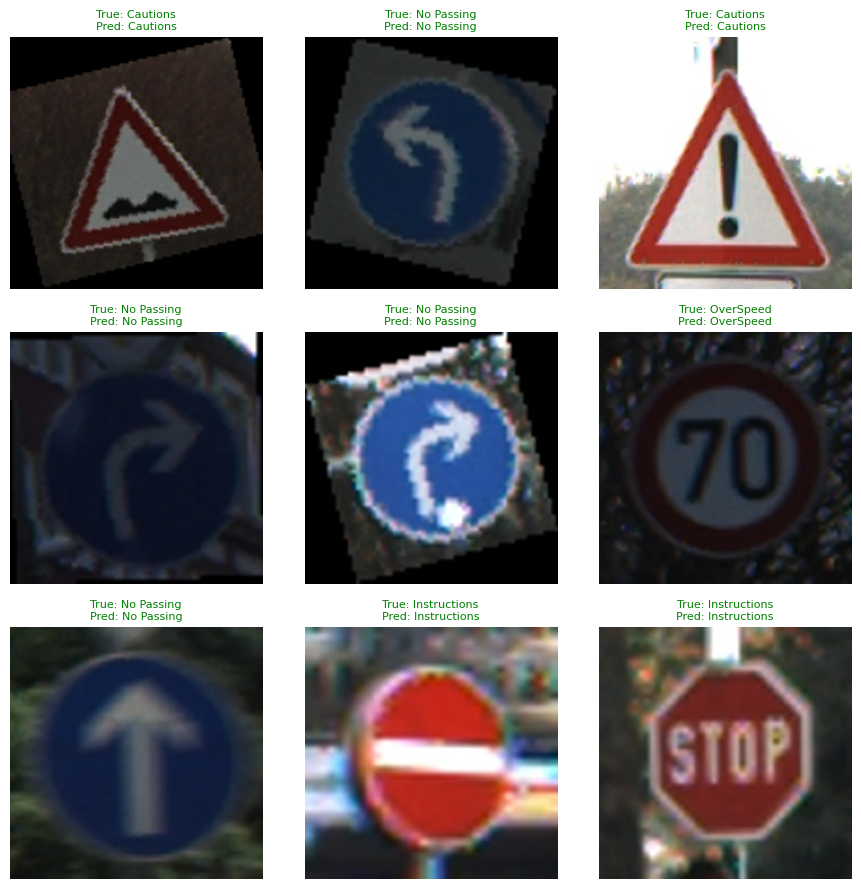

In [ ]:
# Visualise tl model predictions on unseen data
import matplotlib.pyplot as plt
import numpy as np

vis_model = tl_model

# pick one batch from the validation pipeline
for images, labels in test_ds.take(1):
    preds = np.argmax(vis_model.predict(images), axis=1)
    plt.figure(figsize=(9, 9))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        correct = preds[i] == labels[i]
        title_color = "green" if correct else "red"
        plt.title(
            f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}",
            color=title_color, fontsize=8
        )
        plt.axis("off")
    plt.tight_layout()
    break